Импортируем необходимые библиотеки

Логистическая регрессия + набор данных использовались исключительно в качестве примера. На деле же вместо них можно использовать что угодно.

In [ ]:
import numpy as np
import pandas as pd

from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from scipy import stats
from scipy.stats import shapiro

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

В качестве примера решил использовать предобработанный датасет с данными о крушении Титаника.

In [ ]:
df = pd.read_csv('titanic_example_df.csv')
df

,Survived,Name,Sex,Age,SibSp,Parch,Fare,Embarked_Q,Embarked_S,Relatives,...,Fem_and_first,Fem_first_child,Is_Child,Fem_and_child,Low_advantages,High_advantages,Family_Size,Pclass_2,Pclass_3,Male_and_third
0,0.0,4,1,22,1,0,7.2500,0,1,1,...,0,0,0,0.0,0.0,0.0,2,0,1,1
1,1.0,7,0,38,1,0,71.2833,0,0,1,...,1,0,0,0.0,1.0,0.0,2,0,0,0
2,1.0,3,0,26,0,0,7.9250,0,1,0,...,0,0,0,0.0,0.0,0.0,1,0,1,0
3,1.0,7,0,35,1,0,53.1000,0,1,1,...,1,0,0,0.0,1.0,0.0,2,0,0,0
4,0.0,4,1,35,0,0,8.0500,0,1,0,...,0,0,0,0.0,0.0,0.0,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0.0,3,1,27,0,0,13.0000,0,1,0,...,0,0,0,0.0,0.0,0.0,1,1,0,0
887,1.0,4,0,19,0,0,30.0000,0,1,0,...,1,0,0,0.0,1.0,0.0,1,0,0,0
888,0.0,5,0,22,1,2,23.4500,0,1,3,...,0,0,0,0.0,0.0,0.0,4,0,1,0
889,1.0,4,1,26,0,0,30.0000,0,0,0,...,0,0,0,0.0,0.0,0.0,1,0,0,0


Для реализации метода необходимо получить набор предсказаний (вероятностей) + истинных классов

In [ ]:
X = df.drop('Survived', axis = 1).values
y = df['Survived'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True) # делим выборку на тренировочную + тестовую

model = LogisticRegression().fit(X_train, y_train)                                         # обучаем модель
predictions = model.predict_proba(X_test)[:, 1]                                            # получаем набор предсказанных вероятностей

In [ ]:
roc_auc_score(y_test, predictions)

(0.8623853211009174, 179)

In [ ]:
conf = 0.95            # задаем необходимые параметры доверительного интервала
alpha = 1 - conf

n_bootstraps = 10000   # количество Bootstrap выборок
rng_seed = 42          # фиксируем rng_seed для генерации набора индексов (по ним будет происходить генерация новых выборок)
rng = np.random.RandomState(rng_seed) 

labels_size = y_test.shape[0]

metric_values = []     # множество значений нашей метрики

Генерируем 10000 выборок, размеры которых совпадают с исходной. 
На каждой считаем значение целевой метрики.
Полученные значения помещаем в metric_values.

In [ ]:
for i in range(n_bootstraps):
    idx = rng.randint(0, labels_size, labels_size)                       # генерация рандомного набора индексов 
    try:
        step_metric_score = roc_auc_score(y_test[idx], predictions[idx]) # подсчет метрики roc_auc на полученной выборке 
        metric_values.append(step_metric_score) 
    except ValueError:
        pass

Визуализируем полученные результаты

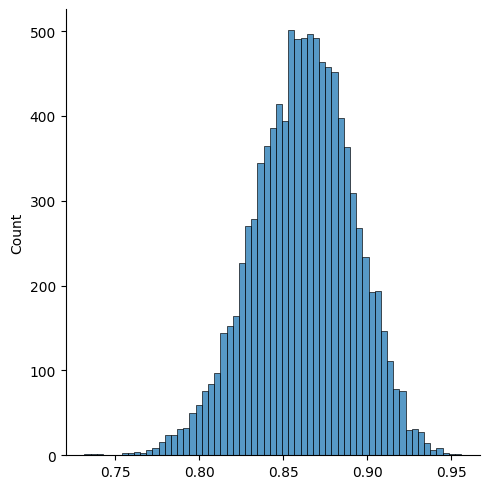

In [ ]:
sns.displot(metric_values);

Проверяем распределение на нормальность для более точной оценки доверительного интервала (используем тест Шапиро-Уилка).

In [ ]:
dist_pvalue = shapiro(metric_values).pvalue
dist_pvalue

1.1698874291185546e-12

В зависимости от характера распределения, используем соответсвующие формулы для подсчета границ доверительного интервала

In [ ]:
if dist_pvalue < 0.05:
    lcb = np.quantile(metric_values, (alpha / 2))
    ucb = np.quantile(metric_values, (1 - (alpha / 2)))
else:
    std = np.std(metric_values)
    mean = np.average(metric_values)
    z = stats.norm.ppf(1 - (alpha / 2))
    lcb = (mean - z * std)
    ucb = (mean + z * std)

lcb, ucb

(0.8004790356625171, 0.9167856455195798)

Визуализируем полученные данные.

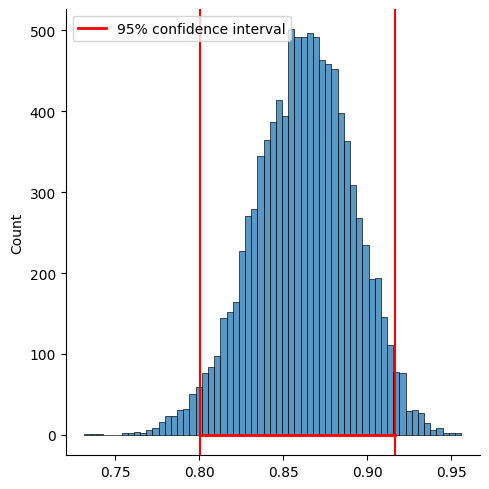

In [ ]:
d = 0.02

sns.displot(metric_values)
plt.plot((lcb, ucb), [-d*2, -d*2], color = 'red', linewidth = 2.0, label = '95% confidence interval')
plt.axvline(lcb, 0, color = 'red')
plt.axvline(ucb, 0, color = 'red')
plt.legend()
plt.show();

Пример ф-ции для подобной задачи.
Для корректной работы необходимо использовать предобученную модель.

In [ ]:
# Example function for pre-trained models

from typing import Tuple
from sklearn.base import ClassifierMixin

def roc_auc_conf_interval_bounds(
    classifier: ClassifierMixin,
    X: np.ndarray,
    y: np.ndarray,
    conf: float = 0.95,
    n_bootstraps: int = 10000,
) -> Tuple[float, float]:
    """Returns confidence bounds of the ROC-AUC"""

    labels_size = len(y)
    predictions = classifier.predict_proba(X)[:, 1]
    predictions_size = len(predictions)

    alpha = 1 - conf
    metric_values = []
    rng_seed = 42
    rng = np.random.RandomState(rng_seed)
    
    for i in range(n_bootstraps):
        idx = rng.randint(0, labels_size, predictions_size)
        try:
            step_metric_score = roc_auc_score(y[idx], predictions[idx])
            metric_values.append(step_metric_score)
        except ValueError:
            pass
    
    p_value = shapiro(metric_values).pvalue

    if p_value < 0.05:
        lcb, ucb = np.quantile(metric_values, (alpha / 2)), np.quantile(metric_values, (1 - (alpha / 2)))
    else:
        std = np.std(metric_values)
        mean = np.average(metric_values)
        z = stats.norm.ppf(1 - alpha / 2)
        lcb, ucb = (mean - z * std), (mean + z * std)   

    return (lcb, ucb)